# Point Pattern Analysis

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
import pysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import dbscan

/opt/anaconda3/envs/gdsbook/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/opt/anaconda3/envs/gdsbook/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Introduction

Points are spatial entities that can be understood in two fundamentally different ways. On the one hand, points can be seen as fixed objects in space, which is to say their location is taken as given (*exogenous*). In this case, analysis of points is very similar to that of other types of spatial data such as polygons and lines. On the other hand, points can be seen as the occurence of an event that could theoretically take place anywhere but only manifests in certain locations. This is the approach we will adopt in the rest of the chapter.

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a *point pattern*. In this case, the location of points is one of the key aspects of interest for analysis. A good example of a point pattern is crime events in a city: they could technically happen in many locations but we usually find crimes are committed only in a handful of them. Point patterns can be *marked*, if more attributes are provided with the location, or *unmarked*, if only the coordinates of where the event occured are provided. Continuing the crime example, an unmarked pattern would result if only the location where crimes were committed was used for analysis, while we would be speaking of a marked point pattern if other attributes, such as the type of crime, the extent of the damage, etc. was provided with the location.

Point pattern analysis is thus concerned with the visualization, description, statistical characerization, and modeling of point patterns, focusing specially on the generating process that gives rise and explains the observed data. *What does the pattern look like?* *What's the nature of the distribution of points?* *Is there any structure we can statistically discern in the way locations are arranged over space?* *Why do events occur in those places and not in others?* These are all questions that point pattern analysis is concerned with. 

At this point, it is useful to remind ourselves of an important disticntion, that between process and pattern. The former relates to the underlying mechanism that is at work to generate the outcome we end up observing. Because of its abstract nature, we do not get to see it. However, in many contexts, the key focus of any analysis is to learn about *what* determines a given phenomenon and *how* those factors combine to generate it. Process in this context is associated with the *how*. Pattern, on the other hand, relates to the result of that process. In some cases, it is the only trace of the process we can observe and thus the only input we have to work with in order to reconstruct it. Although directly observable and, arguably, easier to tackle, pattern is only a reflection of process. The real challenge in many applications is not to characterize the former but to use it to work out the latter.

In this chapter, we will focus on an introduction to point patters through two distinct examples. The first vignette explores a list of world airports, while the second one uses geo-tagged Flickr photos from Tokyo. In both cases, we will treat the phenomena represented in the data as events: airports could theoretically be located in a large set of places on the surface of the earth, however we only find them in very specific places; similarly, photos could be taken of any place in Tokyo, but only certain locations are captured. Keep in mind this understanding of both photos and airports is not inmutable: one could conceive cases where it makes sense to take those locations as given and look at the properties of each of them ignoring their "event" aspect. However, in this context, we will focus on those questions that relate to location and the collective shape of locations. The use of these tools will allow us to transform a long list of unintelligible XY coordinates into tangible phenomena with a characteristic spatial structure, and to answer questions such as how the epicenter of airports differs between hemispheres, or what are the main clusters of attraction in Tokyo for Flickr users.

## Vignette #1: airports

Airports are interesting entities. They are nodes that connect a network of national and international flows, and are its most visible realization. Where they are located is a function of several factors such as the population they are trying to serve, their level of income, the demand for flying, etc. However their exact location is far from the only possible one. Physically speaking, an airport could be built in many more places than where it ends up. This make the process behind an interesting one to explore through the overall "appearance" of their locations; that is, through its pattern.

In this vignette, we will use a preprocessed open dataset collecting XXX. Before we start playing with it, let us load it up:

In [2]:
# Load GeoJSON file
air = gpd.read_file('../data/airports/airports_clean.geojson')
# Check top of the table
air.head()

,scalerank,featurecla,type,name,abbrev,location,gps_code,iata_code,wikipedia,natlscale,...,name_ru,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,x,y,geometry
0,9,Airport,small,Sahnewal,LUH,terminal,VILD,LUH,http://en.wikipedia.org/wiki/Sahnewal_Airport,8.0,...,None,Ludhiana Airport,None,None,None,4,1159113785,8.455503e+06,3.613331e+06,POINT (8455502.603945348 3613330.732570527)
1,9,Airport,mid,Solapur,SSE,terminal,VASL,SSE,http://en.wikipedia.org/wiki/Solapur_Airport,8.0,...,None,None,None,None,None,4,1159113803,8.452830e+06,1.993750e+06,POINT (8452829.54809133 1993750.242252401)
2,9,Airport,mid,Birsa Munda,IXR,terminal,VERC,IXR,http://en.wikipedia.org/wiki/Birsa_Munda_Airport,8.0,...,None,M. O. Ranchi,None,Sân bay Birsa Munda,蘭契,4,1159113831,9.498179e+06,2.670488e+06,POINT (9498179.37479558 2670487.543431391)
3,9,Airport,mid,Ahwaz,AWZ,terminal,OIAW,AWZ,http://en.wikipedia.org/wiki/Ahwaz_Airport,8.0,...,None,Ahwaz International Airport,Ahvaz Havalimanı,Sân bay Ahvaz,阿瓦士,4,1159113845,5.426503e+06,3.677395e+06,POINT (5426503.078078241 3677395.464003531)
4,9,Airport,mid and military,Gwalior,GWL,terminal,VIGR,GWL,http://en.wikipedia.org/wiki/Gwalior_Airport,8.0,...,None,Gwalior Airport,None,Sân bay Gwalior,瓜廖爾,4,1159113863,8.707101e+06,3.034483e+06,POINT (8707100.951900087 3034482.998676365)


A point pattern is essentially the collective shape a bunch of points create. Given the table contains the XY coordinates of each airport, the quickest way to get a first sense of what the data look like is to plot it raw:

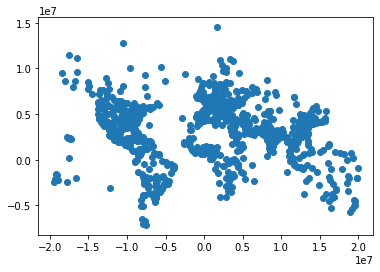

In [3]:
# Plot XY coordinates
plt.scatter(air.x, air.y)

This is not very pretty but that is not the point. Our goal was to get a quick first picture and this approach has done the job. Things we can learn from this figure include the fact the overall shape should look familiar to anyone who's seen a map of the world and that, thus, the data do not seem to have any obvious errors. We can then move on to do more interesting things with it.

The first extension is to bring geographic context. Although the shape of the figure above might be familiar, it still takes some effort to identify where different dots are placed on the surface of the Earth. An easy solution to make this easier is to overlay it with a tile map downloaded from the internet. Let us do just that: first we'll download the tiles into an image object, and the we will plot it together with the airports dataset.

In [4]:
# Download tiles for the bounding box of the airport's GeoDataFrame
%time img, ext = ctx.bounds2img(*air.total_bounds, 2)

CPU times: user 250 ms, sys: 35.6 ms, total: 286 ms
Wall time: 1.07 s


The method `bounds2img` (from the library `contextily`, `ctx` for short) returns the image object (`img`) and also an auxilliary tuple with its exact geographic bounds:

In [5]:
ext

(-20037508.342789244,
 20037508.342789244,
 -10018754.171394624,
 20037508.342789244)

This allows us then to match it up with other data which is also expressed in the same coordinate reference system (CRS). Let us produce a slightly more useful image than above:

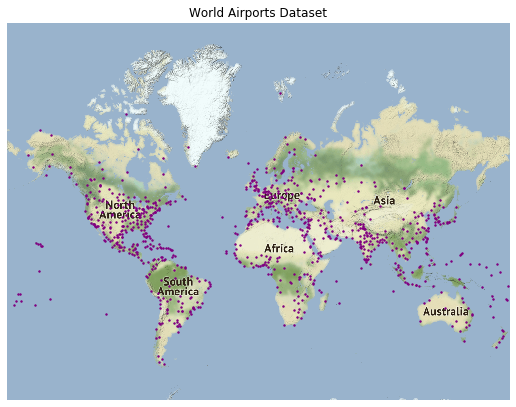

In [6]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title('World Airports Dataset')
# Display
plt.show()

Now this looks a bit better!

### Centrography

- Central tendency: (weighted) mean center --> weight by `scalerank`

- Dispersion: std distance

* Shape analysis: convex hull

### Point-in-polygon visualization

Commonly, we either need or want to link points to areal geographies that allow us to augment their attribute list, or to look at the problem at hand from a new perspective. Maybe because the process we are interested in operates at a more aggregated level, or maybe because by aggregating we can obtain a view into the data that makes it simpler to understand. 

For example, the figure above gives us a good sense about how airports are distributed overall but, in particularly dense areas like Europe, it is hard to see much. By aggregating them to say the country geography, we can consider new sets of questions such as which countries have most airports or which ones have a larger density. This works because the geography we want to aggregate it to, countries, is meaningful. This means it has some inherent structure that confers value. In this case, countries are relevant entities and a crucial piece in arranging the world.

The first thing we need to do to create a country map is to have country (spatial) data. Let us load up a cleaned table with countries:

In [7]:
# Load up shapefile with countries
ctys = gpd.read_file('../data/airports/countries_clean/countries_clean.shp')

DriverError: ../data/airports/countries_clean/countries_clean.shp: No such file or directory

And, same as with any new dataset, let us have a quick look at what it looks like and how it stacks up with the other data we have collected along the way:

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add tile map
ax.imshow(img, extent=ext)
# Display country layer
ctys.plot(ax=ax, linewidth=0.1, \
          edgecolor='0.8', color='0.2')
# Display airport locations
ax.scatter(air.x, air.y, c='yellow', s=2, linewidth=0.)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title('World Airports Dataset')
# Display
plt.show()

Again nothing new or too exciting from this figure, but this is good news: it means our data are aligned and match up nicely. So we can move on to more interesting ventures.

The next thing that we might want to do to obtain country counts of airports is to link each airport with the country where it is located. Sometimes, we are lucky and the airport table will include a column with that information. In this case, we need to create it for ourselves. This is a well-known problem in geometry and GIS and is commonly known as point-in-polygon: to determine whether a given point is inside a polygon. With that operation solved, linking airports to countries amoutns to a bit of house keeping. We will first explore in pure Python how that algorithm can be easily implemented from scratch so it becomes clear what steps are involved; then we will see a much more efficient and fast implementation that we should probably use when need to perform this operation in other contexts.

---
**NOTE**: skip next if all you want to know is how to perform a standard spatial join

Creating a manual, brute-force implementation of a spatial join is not very difficult, if one has solved the problem of checking whether a point is inside a polygon or not. Thanks to the library that provides geometry objects to `geopandas` (`shapely`), this is solved in Python. For example, we can easily check if the first dot on the airports table is inside the first polygon in the countries table:

In [ ]:
# Single out point
pt = air.iloc[0]['geometry']
# Single out polygon
poly = ctys.iloc[0]['geometry']
# Check whether `poly` contains `pt`
poly.contains(pt)

That easy. As we can see, the method `contains` in any `shapely` geometry makes it trivial. So, the first airport in the list is not in the first country of the list.

To find which country every airport is in easily (albeit not very efficiently!), we need to sift through all possible combinations to see if any of them gives us a match. Once we find it for a given airport, we need to record that and move on, no need to keep checking. That is exactly what we do in the cell below:

In [ ]:
%%time
# Set up an empty dictionary to populate it with the matches
airport2country = {aID: None for aID in air.index}
# Loop over every airport
for aID, row_a in air.iterrows():
    # Single out location of the airport for convenience
    pt = row_a['geometry']
    # Loop over every country
    for cID, row_p in ctys.iterrows():
        # Single out country polygon for convenience
        poly = row_p['geometry']
        # Single out country name for convenience
        cty_nm = row_p['ADMIN']
        # Check if the country contains the airport
        if poly.contains(pt):
            # If so, store in the dictionary
            airport2country[aID] = cty_nm
            # Move on to the next airport, skipping remaining 
            # countries (an airport cannot be in two countries 
            # at the same time)
            break
airport2country = pd.Series(airport2country)

Once run, we can check the content of the dictionary we have created (after converting it to a `Series` for convenience):

In [ ]:
pd.DataFrame({'Airport Name': air['name'], 'Country': airport2country}).head(10)

---

Although interesting from a pedagogical standpoint, in practive, very rarely do we have to write a spatial join algorithm from scratch. More commonly, we will use one of the already available packaged methods. As mentioned, this is a fairly standard GIS operation, and the GIS community has spent a lot of effort to build optimized algorithms that can conveniently do the job for us. In `GeoPandas`, this is as simple as calling `sjoin`:

In [ ]:
# Spatial join
%time air_w_cty = gpd.sjoin(air, ctys)
air_w_cty.head()

Instead of the $\approx$47 seconds it took our homemade algorithm, the one above did a full join in just over two seconds! Through this join also, it is not only the IDs that are matched, but the entire table. Let us quickly compare whether the names match up with our own:

In [ ]:
# Display only top six records of airport and country name
# Note that the order of the `sjoin`ed table is not the same
# as ours but it can easily be rearranged using original indices
air_w_cty.loc[range(6), ['name', 'ADMIN']]

Voila! Both tables seem to match nicely.

To finish this vignette, let us explore which countries have the most airports through a simple choropleth. The only additional step we need to take is to obtain counts per country. But this is pretty straightforward now we have them linked to each airport. To do this, we use the `groupby` operation which, well, groups by a given column in a table, and then we apply the method `size`, which tells us how many elements every group has:

In [ ]:
# Group airports by country and count by group
cty_counts = air_w_cty.groupby('ADMIN')\
                      .size()

Then a choropleth is as simple as:

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Index countries by the name, append the airport counts
# (which are themselves indexed on country names too),
# Fill any missing value in the count with zero (no counts
# in this context means zero airports), and display choropleth
# using quantiles
p = ctys.set_index('ADMIN')\
        .assign(airport_count=cty_counts)\
        .fillna(0)\
        .plot(column='airport_count', scheme='Quantiles', \
              ax=ax, linewidth=0, legend=True)
# Display map
plt.show()

Maybe unsurprisingly, what we find after all of this is that larger countries such as Canada, US, or Russia, have more airports. However, we can also find interesting insights. Some countries with similar size, such as France or Germany and some African countries such as Namibia have very different numbers. This should trigger further questions as to why that is, and maybe even suggest some tentative answers.

And additional view that might be of interest is to display airport counts, but weighted by the area of the country. In other words, to show airport density. The idea behind it is to explore the variation in probabilities of an airport to be located in a given country, irrespective of how large that country is. Let us first create the densities:

In [ ]:
# Airport density
# Note since the CRS we are working with is expressed in Sq. metres,
# we rescale it so the numbers are easier to read
airport_density = cty_counts * 1e12 / ctys.set_index('ADMIN').area

airport_density.head()

And now we are ready to plot!

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Index countries by the name, append the airport densities
# (which are themselves indexed on country names too),
# Fill any missing value in the count with zero (no number
# in this context means zero airports), and display choropleth
# using quantiles
p = ctys.set_index('ADMIN')\
        .assign(airport_dens=airport_density)\
        .fillna(0)\
        .plot(column='airport_dens', scheme='Quantiles', \
              ax=ax, linewidth=0, legend=True)
# Display map
plt.show()

This map gives us a very different view. Very large countries are all of a sudden "penalized" and some smaller ones rise to the highest values. Again, how to read this map and whether its message is interesting or not depends on what we are after. But, together with the previous one, it does highlight important issues to consider when exploring uneven spatial data and what it means to display data (e.g. airports) through specific geographies (e.g. countries).

## Vignette #2: Images of Tokyo

The rise of new forms of data such as geotagged photos uploaded to online services is creating new ways for researchers to study and understand cities. Where to people take pictures? When are those pictures taken? Why certain places attract many more photographers than others? All these questions and more become more than just rethorical ones when we consider volunteered geographic information (VGI, [Goodchild, 2007](https://link.springer.com/article/10.1007%2Fs10708-007-9111-y)) in the form of online photo hosting services. In this vignette we will explore metadata from a sample of georeferenced images uploaded to [Flickr](https://www.flickr.com/) and extracted thanks to the [100m Flickr dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67). To do that, we will introduce a few approaches that help us better understand the distribution and characteristics of a point pattern. To get started, let's load the data first:

In [ ]:
db = pd.read_csv('../data/tokyo_clean.csv')

The table we will use has been lightly processed from the raw data, and contains the user ID, the latitude and longitude, as well as those coordinates expressed in Pseudo Mercator, the timestamp when the photo was taken, and the url of th picture they refer to:

In [ ]:
db.head()

### Visualization

The first step to get a sense of what the spatial dimension of this dataset looks like is to plot it. At its most basic level, we can generate a scatter plot with a single line:

In [ ]:
# Generate scatter plot
sns.jointplot(x='longitude', y='latitude', data=db, s=0.5);

This is a good start: we can see dots, far from randomly, tend to be concentrated in the center of the covered area; furthermore, within the broad patter, we can also see there seems to be more localised clusters. However, the plot above has two key drawbacks: one, it lacks geographical context; and two, there are areas where the density of points is so large that it is hard to tell anything beyond a blue blurb. 

Start with the context. The easiest way to provide additional context is by ovelaying a tile map from the internet. Let us quickly call `contextily` for that. We first obtain the bounding box of the point pattern:

In [ ]:
# Extract bounding box from the `x` and `y` columns
bbox = [db.x.min(), db.y.min(), db.x.max(), db.y.max()]

And then pull the tiles down:

In [ ]:
# Download map tiles
%time img, ext = ctx.bounds2img(*bbox, 11)

#### Dots on a map

Adding them brings a lot more clarity to why the dots are distributed the way they are:

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(img, extent=ext, alpha=0.5)
# Plot photograph points
ax.scatter(db['x'], db['y'], s=0.75)
# Display
plt.show()

#### Hex-binning

Let us now take care of the second problem: dense areas becoming a big blurb where it is hard to tell any pattern or see through to explore the characteristics of the area. For example, in the middle of the map, towards the right, there is the highest concentration of pictures taken; this sheer amount of dots on the maps in some parts obscures whether all of that area receives as many pics or whether, within there, some places receive a particularly high degree of attention.

The first solution for this, which has become very popular in the last few years, is to generate a regular grid (either squared or hexagonal), count how many dots each polygons has, and present it as we would any other choropleth. This is attractive because it is simple, intuitive, and the regular grid removes some of the area distortions choropleths may imply. We will use hexagonal binning (also called hexbin) because it has slightly nicer properties than squared grids, such as larger flexibility in the shape and better connectivity between cells. Creating a hexbin is rather straightforward in Python:

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Generate and add hexbin with 50 hexagons in each 
# dimension, not borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(db['x'], db['y'], \
               gridsize=50, linewidths=0, \
               alpha=0.5, cmap='viridis_r')
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Voila, this allows a lot more detail! It is now clear that the majority of photographs relate to much more localised areas and that the previous map was obscuring this.

#### Kernel Density Estimation (KDE)

Grids are the spatial equivalent of a histogram: the user decides how many "buckets", and the points are counted within them in a discrete fashion. This is fast, efficient, and potentially very detailed (if many bins are created). However, it does represent a discretisation of an essentially contiguous phenomenon and, as such, it may introduce distortions (e.g. MAUP). An alternative approach is to instead create what is known as a kernel density estimation (KDE): an empirical approximation of the probability density function. This approach is covered in detail elsewhere (e.g. [Silverman 1986](https://books.google.co.uk/books?hl=en&lr=&id=e-xsrjsL7WkC&oi=fnd&pg=PR9&dq=Silverman,+B.+W.+(1986)&ots=ixJrnv0GXo&sig=pMOnWU2UYmJ5SYpGWsnXtBgS_LI#v=onepage&q=Silverman%2C%20B.%20W.%20(1986)&f=false)), but we can provide the intuition here. Instead of overlaying a grid of squares of hexagons and count how many points fall within each, a KDE lays a grid of points over the space of interest on which it places kernel functions that count points around them with different weight based on the distance. These counts are then aggregated to generate a global surface with probability. The most common kernel function is the gaussian one, which applies a normal distribution to weight points. The result is a continuous surface with a probability function that may be evaluated at every point. Creating a gaussian kernel in Python is rather straightfoward:

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Generate and add KDE with a shading of 50 gradients 
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
sns.kdeplot(db['x'], db['y'], \
            n_levels=50, shade=True, \
            alpha=0.25, cmap='viridis_r')
# Remove axes
ax.set_axis_off()

The result is a much smoother output that captures the same structure of the hexbin but eases the transitions between different areas. This provides a better generalisation of the probability function which, in some cases, is useful.

### Testing for non-randomness

- quadrat
- distance based
- k-functions
- bi-variate k

### Identifying clusters

In this final section, we will learn a method to identify clusters of points, based on their density across space. To do this, we will use the widely used `DBSCAN` algorithm. For this method, a cluster is a concentration of at least `m` points, each of them within a distance of `r` of at least another point in the cluster. Points in the dataset are then divided into three categories:

* *Noise*, for those points outside a cluster.
* *Cores*, for those points inside a cluster whith at least `m` points in the cluster within distance `r`.
* *Borders* for points inside a cluster with less than `m` other points in the cluster within distance `r`.

Both `m` and `r` need to be prespecified by the user before running `DBSCAN`. This is a critical point, as their value can influence significantly the final result. Before exploring this in greater depth, let us get a first run at computing `DBSCAN` in Python.

In [ ]:
# Compute DBSCAN
cs, lbls = dbscan(db[['x', 'y']])

The function returns two objects, which we call `cs` and `lbls`. `cs` contains the indices (order, starting from zero) of each point which is classified as a *core*. We can have a peek into it to see what it looks like:

In [ ]:
# Print the first 5 elements of `cs`
cs[:5]

The printout above tells us that the second (remember, Python starts counting at zero!) point in the dataset is a core, as it is the 23rd, 31st, 36th, and 43rd. The object `cs` always has a variable length, depending on how many cores the algorithm finds.

Now let us have a look at `lbls`, short for labels:

In [ ]:
lbls[:5]

The labels object always has the same length as the number of points used to run `DBSCAN`. Each value represents the index of the cluster a point belongs to. If the point is classified as *noise*, it receives a -1. Above, we can see that the second point belongs to cluster 1, while the others in the list are effectively not part of any cluster. To make thinks easier later on, let us turn `lbls` into a `Series` object that we can index in the same way as our collection of points:

In [ ]:
lbls = pd.Series(lbls, index=db.index)

Now we already have the clusters, we can proceed to visualize them. There are many ways in which this can be done. We will start just by coloring points in a cluster in red and noise in grey:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add base layer with tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(db.loc[db.index.difference(noise.index), 'x'], \
           db.loc[db.index.difference(noise.index), 'y'], \
          c='red', linewidth=0)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

Although informative, the result of this run is not particularly satisfactory. XXX. This is because we have run `DBSCAN` with the default parameters. If you type `dbscan?`, you will get the help of the function and will be able to see what those are: a radious of 0.5 and a minimum of five points per cluster. Since our data is expressed in metres, a radius of half a metre will only pick up hyper local clusters. This might be of interest in some cases but, in others, it can result in odd outputs. 

Let us change those parameters to see if we can pick up more general patterns. For example, let us say a cluster needs to, at least, have roughly 1% of all the points in the dataset:

In [ ]:
# Obtain the number of points 1% of the total represents
minp = np.round(db.shape[0] * 0.01)
minp

At the same time, let us expand the maximum radious to say, 500 metres. Then we can re-run the algorithm and plot the output, all in the same cell this time:

In [ ]:
# Rerun DBSCAN
cs, lbls = dbscan(db[['x', 'y']], eps=500, min_samples=minp)
# Turn labels into a Series
lbls = pd.Series(lbls, index=db.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add base layer with tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(db.loc[db.index.difference(noise.index), 'x'], \
           db.loc[db.index.difference(noise.index), 'y'], \
          c='red', linewidth=0)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

- Convex hull (`shapely`) of each cluster

In [ ]:
chs = []
for cID in lbls.unique():
    if cID != -1:
        cluster = db.loc[lbls==cID]
        geom = cluster.loc[:, ['x', 'y']].apply(\
                                    lambda xy: Point(*xy), axis=1
                                               )
        ch = MultiPoint(geom.tolist()).convex_hull
        chs.append(ch)
chs = gpd.GeoSeries(chs)

In [ ]:
# Rerun DBSCAN
cs, lbls = dbscan(db[['x', 'y']], eps=500, min_samples=minp)
# Turn labels into a Series
lbls = pd.Series(lbls, index=db.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add base layer with tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, \
           linewidth=0, alpha=0.75)
# Plot convex hulls
chs.plot(ax=ax, color='red', alpha=0.5, linewidth=0.)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.

In [ ]:
print("done")